# Geolocating NetCDF
Be able to get lat/lon from NetCDF in polar stereographic format.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import requests
from bs4 import BeautifulSoup
import os
import icedyno.preprocess.geolocation as ipg
import xarray as xr

# Download 1km IMS netcdf files
Defaults to not downloading the 1km netcdf IMS files.

In [2]:
years = range(2014, 2025)
root_dir = "../../data/ims_1km/"
download = False
if download:
    for yr in years:
        print(f"Downloading files for {yr}")
        save_dir = f"{root_dir}/{yr}/"
        os.makedirs(save_dir, exist_ok=True)

        html_page = f"https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/1km/{yr}/"
        response = requests.get(html_page)

        try:
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, "html.parser")
                links = soup.find_all("a")
                file_cnt = 0
                for link in links:
                    href = link.get("href")
                    if ".nc" in href:
                        download_url = f"{html_page}/{link['href']}"
                        response = requests.get(download_url, stream=True)
                        response.raise_for_status()

                        file_name = f"{save_dir}{os.path.basename(download_url)}"

                        with open(file_name, "wb") as file:
                            for chunk in response.iter_content(chunk_size=512):
                                file.write(chunk)

                        file_cnt += 1
                        if file_cnt % 50 == 0:
                            print(f"Downloading files for {yr}: [{file_cnt}]")

        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")

        print(f"Total downloaded files for {yr}: [{file_cnt}]\n")

## Functions

In [3]:
def plot_sie(sie: np.array, marker: tuple = None):
    colors = ["#E500E5", "#0066FF", "#01FF00", "#FFC100", "#E50000"]
    cmap = ListedColormap(colors, name="custom_colormap", N=len(colors))

    # Plotting the sea ice extent with the custom colormap
    plt.figure(figsize=(10, 10))
    plt.imshow(sie, cmap=cmap, vmin=0, vmax=len(colors) - 1)
    plt.title("Sea Ice Extent around the Arctic Circle", fontsize=12)
    plt.axis("off")

    # Adding a colorbar with labels for different surface types
    cbar = plt.colorbar(ticks=range(len(colors)))
    cbar.ax.set_yticklabels(
        [
            "Outside Northern Hemisphere",
            "Open Water",
            "Land without Snow",
            "Sea or Lake Ice",
            "Snow Covered Land",
        ]
    )
    cbar.set_label("Surface Type")
    if marker:
        plt.scatter(marker[0], marker[1], s=500, c="green", marker="o")

    plt.show()

In [4]:
def find_closest_index_in_grid(target: float, coordinates: np.array) -> int:
    """
    Given a target coordinate in projected coordinates (x or y) and the list of coordinates, return the index of the closest number in the coordinates.
    Assumes a 1km grid.
    """
    assert np.allclose(coordinates % 1000, 500)
    start = coordinates[
        0
    ]  # Assume that the first element of coordinates is the minimum number in the list
    # -12287500.0 for IMS 1km data.

    # Define the step size
    grid_resolution = 1000  # meters

    # Calculate the index of the closest number
    index = int((target - start) // grid_resolution)

    # If the solution is correct, the target and the found value should never be more than the grid_resolution apart.
    assert abs(coordinates[index] - target) < grid_resolution
    return index

## Load file

In [5]:
file_path = "../../data/ims_netcdf_1km_cropped_4_000_000m_window/2015/ims2015164_1km_v1.3_grid4000.nc"
file_path = "../../data/ims_netcdf_1km_cropped_2_000km_window/2015/ims2015164_1km_v1.3_grid2000_74,0lat_-140,0lon.nc"
file_path = "../../data/ims_1km/2015/ims2015164_1km_v1.3.nc"

In [ ]:
with h5py.File(file_path, "r") as file:
    sie = file["IMS_Surface_Values"][:]
    x_coords = file["x"][:]
    y_coords = file["y"][:]

## Prototyping the netcdf grid correction

In [6]:
lon = -140
lat = 74
x, y = ipg.polar_lonlat_to_xy(longitude=lon, latitude=lat)

In [7]:
x, y

(-1078660.2392965402, 1285497.2153701815)

In [8]:
ipg.polar_xy_to_lonlat(x, y)

(-140.0, 73.99999999912433)

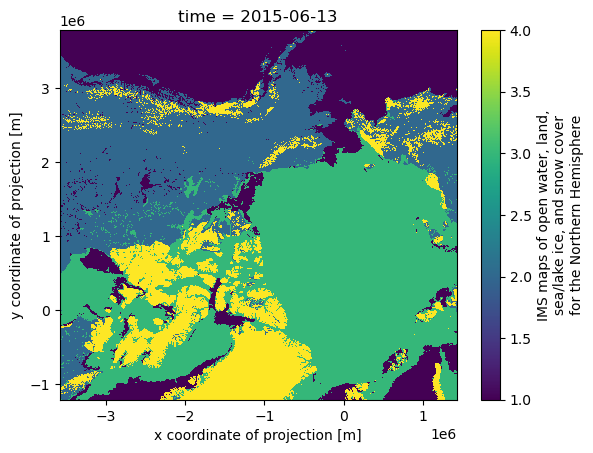

In [21]:
with xr.open_dataset(file_path, engine="h5netcdf") as ds:
    window = 2000 * 1000  # from km to meters
    rotated_sie = np.rot90(
        ds["IMS_Surface_Values"].values[0], k=1, axes=(0, 1)
    )  # Rotate the 2D array
    test = rotated_sie.reshape((1, rotated_sie.shape[0], rotated_sie.shape[1]))
    data_xr = xr.DataArray(
        test, coords={"y": ds.y, "x": ds.x, "time": ds.time}, dims=["time", "y", "x"]
    )
    ds["IMS_Surface_Values"].loc[:, :] = data_xr
    cropped_ds = ds.sel(
        x=slice(x - window // 2, x + window // 2),
        y=slice(y - window // 2, y + window // 2),
    )
    cropped_ds.IMS_Surface_Values.plot()
    cropped_ds.to_netcdf("rotated_test_file.nc")
    ds.to_netcdf("rotated_ds_test_file.nc")

In [ ]:
plot_sie(
    cropped_ds.IMS_Surface_Values.values[0],
    marker=(
        cropped_ds.IMS_Surface_Values.values[0].shape[0] // 2,
        cropped_ds.IMS_Surface_Values.values[0].shape[1] // 2,
    ),
)

In [ ]:
from pyproj import Proj, transform

# Define the projection using the Proj4 string
proj = Proj(
    "+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356257 +ellps=WGS84 +datum=WGS84 +units=m +no_defs",
)

# Convert geographic coordinates to projection coordinates (x, y)
x, y = proj(lon, lat)

print(f"Projected coordinates: x={x}, y={y}")

# To go the other way, from projection coordinates to geographic coordinates:
lon, lat = proj(x, y, inverse=True)
print(f"Geographic coordinates: lon={lon}, lat={lat}")

In [ ]:
x_coord = find_closest_index_in_grid(x, x_coords)
y_coord = find_closest_index_in_grid(y, y_coords)
print(x_coord, y_coord)
window = 2000
plot_sie(
    sie[0][x_coord - window : x_coord + window, y_coord - window : y_coord + window],
    marker=(window, window),
)

In [ ]:
from osgeo import gdal

input_file = (
    "../../data/ims_1km/ims2020001_1km_GIS_v1.3.tif"  # ims_2020335_1km_GIS_v1.3.nc'
)
output_file = "output.tif"

gdal.Warp(
    output_file,
    input_file,
    options="-t_srs EPSG:4326 "
    "-te -180 -90 180 90 "
    "-srcnodata {} ".format(0) + "-r near "
    "-of NetCDF "
    "-co COMPRESS=deflate "
    "-wo NUM_THREADS=4",
    geoloc=True,
)

In [ ]:
def polarstereo_fwd(
    phi, lambda_, a=6378137, f=291.505347349177, phi_c=60, lambda_0=-80
):
    """
    Transforms lat/lon data to map coordinates for a polar stereographic system.

    Parameters:
    - phi (float or array-like): Latitude in decimal degrees. Negative for S.
    - lambda_ (float or array-like): Longitude in decimal degrees. Negative for W.
    - a (float): Earth radius in meters.
    - f (float): Flattening of the ellipsoid.
    - phi_c (float): Latitude of true scale in degrees.
    - lambda_0 (float): Meridian along the positive Y axis of the map in degrees.

    Returns:
    - x (float or array-like): X map coordinates.
    - y (float or array-like): Y map coordinates.
    """
    e = 0.08275970933894519  # np.sqrt(2 / f - 1 / f**2)  # Calculate eccentricity from flattening
    phi = np.radians(phi)
    phi_c = np.radians(phi_c)
    lambda_ = np.radians(lambda_)
    lambda_0 = np.radians(lambda_0)

    t = np.tan(np.pi / 4 - phi / 2) / (
        (1 - e * np.sin(phi)) / (1 + e * np.sin(phi))
    ) ** (e / 2)
    t_c = np.tan(np.pi / 4 - phi_c / 2) / (
        (1 - e * np.sin(phi_c)) / (1 + e * np.sin(phi_c))
    ) ** (e / 2)
    m_c = np.cos(phi_c) / np.sqrt(1 - e**2 * np.sin(phi_c) ** 2)
    rho = a * m_c * t / t_c
    m = np.cos(phi) / np.sqrt(1 - e**2 * np.sin(phi) ** 2)

    x = rho * np.sin(lambda_ - lambda_0)
    y = -rho * np.cos(lambda_ - lambda_0)

    return x, y

In [ ]:
def polarstereo_inv(
    x,
    y,
    a=6378137,
    e=0.08275970933894519,  # np.sqrt(2 / 291.505347349177 - 1 / 291.505347349177**2),
    phi_c=60,
    lambda_0=-80,
):
    """
    Transforms map coordinates to lat/lon for a polar stereographic system using the IMS v3 Projection parameters.

    Parameters:
    - x, y: Map coordinates (scalars, vectors, or matrices of equal size).

    Constants for IMS v3 Projection:
    - a: Earth radius in meters (6378137 for WGS84).
    - e: Earth eccentricity derived from flattening.
    - phi_c: Latitude of true scale in degrees (60 for IMS v3).
    - lambda_0: Meridian along the positive Y axis of the map in degrees (-80 for IMS v3).

    Returns:
    - phi: Latitude in decimal degrees.
    - lambda: Longitude in decimal degrees.
    """

    # Convert degrees to radians
    phi_c = np.radians(phi_c)
    lambda_0 = np.radians(lambda_0)

    # Compute constants
    t_c = np.tan(np.pi / 4 - phi_c / 2) / (
        (1 - e * np.sin(phi_c)) / (1 + e * np.sin(phi_c))
    ) ** (e / 2)
    m_c = np.cos(phi_c) / np.sqrt(1 - e**2 * np.sin(phi_c) ** 2)
    rho = np.sqrt(x**2 + y**2)
    t = rho * t_c / (a * m_c)

    # Compute latitude using the series expansion
    chi = np.pi / 2 - 2 * np.arctan(t)
    phi = (
        chi
        + (e**2 / 2 + 5 * e**4 / 24 + e**6 / 12 + 13 * e**8 / 360)
        * np.sin(2 * chi)
        + (7 * e**4 / 48 + 29 * e**6 / 240 + 811 * e**8 / 11520) * np.sin(4 * chi)
        + (7 * e**6 / 120 + 81 * e**8 / 1120) * np.sin(6 * chi)
        + (4279 * e**8 / 161280) * np.sin(8 * chi)
    )

    # Compute longitude
    lambda_ = lambda_0 + np.arctan2(x, -y)

    # Adjust signs and ranges
    phi = np.degrees(phi)
    lambda_ = np.degrees(lambda_)
    lambda_ = (lambda_ + 180) % 360 - 180  # Normalize to [-180, 180]

    return phi, lambda_


# Example usage
# Assuming x, y are the map coordinates for which you want to find the latitude and longitude.
x = -1540033.6
y = -560526.4
phi, lambda_ = polarstereo_inv(x, y)
print(f"Latitude: {phi}, Longitude: {lambda_}")

In [ ]:
def polarstereo_inv(x, y):
    """
    Transforms map coordinates to lat/lon for a polar stereographic system.

    Parameters:
    - x, y: Map coordinates (scalars, vectors, or matrices of equal size).

    Constants:
    - a: Earth radius in meters (default is 6378137.0 for WGS84).
    - e: Earth eccentricity (default is 0.08181919 for WGS84).
    - phi_c: Latitude of true scale in degrees (default is -70).
    - lambda_0: Meridian along the positive Y axis of the map in degrees (default is 0).

    Returns:
    - phi: Latitude in decimal degrees.
    - lambda: Longitude in decimal degrees.
    """
    a = 6378137.0
    e = 0.08181919
    phi_c = 60
    lambda_0 = 80

    # Convert degrees to radians
    phi_c = np.radians(phi_c)
    lambda_0 = np.radians(lambda_0)

    # Determine hemisphere based on phi_c
    pm = -1 if phi_c < 0 else 1
    if pm < 0:
        phi_c = -phi_c
        lambda_0 = -lambda_0
        x, y = -x, -y
        print(x, y)

    # Compute constants
    t_c = np.tan(np.pi / 4 - phi_c / 2) / (
        (1 - e * np.sin(phi_c)) / (1 + e * np.sin(phi_c))
    ) ** (e / 2)
    m_c = np.cos(phi_c) / np.sqrt(1 - e**2 * np.sin(phi_c) ** 2)
    rho = np.sqrt(x**2 + y**2)
    t = rho * t_c / (a * m_c)

    # Compute latitude using the series expansion
    chi = np.pi / 2 - 2 * np.arctan(t)
    phi = (
        chi
        + (e**2 / 2 + 5 * e**4 / 24 + e**6 / 12 + 13 * e**8 / 360)
        * np.sin(2 * chi)
        + (7 * e**4 / 48 + 29 * e**6 / 240 + 811 * e**8 / 11520) * np.sin(4 * chi)
        + (7 * e**6 / 120 + 81 * e**8 / 1120) * np.sin(6 * chi)
        + (4279 * e**8 / 161280) * np.sin(8 * chi)
    )

    # Compute longitude
    lambda_ = lambda_0 + np.arctan2(x, -y)

    # Adjust signs and ranges
    phi = pm * np.degrees(phi)
    lambda_ = pm * np.degrees(lambda_)
    lambda_ = (lambda_ + 180) % 360 - 180  # Normalize to [-180, 180]

    return phi, lambda_

In [ ]:
def polarstereo_fwd(phi, lambda_):
    """
    Transforms lat/lon data to map coordinates for a polar stereographic system.

    Parameters:
    - phi (float or array-like): Latitude in decimal degrees. Negative for S.
    - lambda_ (float or array-like): Longitude in decimal degrees. Negative for W.

    Constants:
    - a (float): Earth radius in meters (default is 6378137.0 for WGS84).
    - e (float): Earth eccentricity (default is 0.08181919 for WGS84).
    - phi_c (float): Latitude of true scale in degrees (default is -70).
    - lambda_0 (float): Meridian along the positive Y axis of the map in degrees (default is 0).

    Returns:
    - x (float or array-like): X map coordinates.
    - y (float or array-like): Y map coordinates.
    """
    a = 6378137.0
    e = 0.08181919
    phi_c = 60
    lambda_0 = 80

    # Convert to radians
    phi = np.radians(phi)
    phi_c = np.radians(phi_c)
    lambda_ = np.radians(lambda_)
    lambda_0 = np.radians(lambda_0)

    # If the standard parallel is in the Southern Hemisphere, switch signs
    pm = -1 if phi_c < 0 else 1
    if pm < 0:
        phi = -phi
        phi_c = -phi_c
        lambda_ = -lambda_
        lambda_0 = -lambda_0

    # Calculate terms
    t = np.tan(np.pi / 4 - phi / 2) / (
        (1 - e * np.sin(phi)) / (1 + e * np.sin(phi))
    ) ** (e / 2)
    t_c = np.tan(np.pi / 4 - phi_c / 2) / (
        (1 - e * np.sin(phi_c)) / (1 + e * np.sin(phi_c))
    ) ** (e / 2)
    m_c = np.cos(phi_c) / np.sqrt(1 - e**2 * np.sin(phi_c) ** 2)
    rho = a * m_c * t / t_c
    m = np.cos(phi) / np.sqrt(1 - e**2 * np.sin(phi) ** 2)

    # Calculate coordinates
    x = pm * rho * np.sin(lambda_ - lambda_0)
    y = -pm * rho * np.cos(lambda_ - lambda_0)

    return x, y

In [ ]:
print(lon, lat)
x, y = polarstereo_fwd(lon, lat)  # phi, lambda_)
print(polarstereo_inv(x, y))
print(x, y)

### Testing X, Y Polar Sterographic to Lat Lon

In [ ]:
# Define a list of test cases with x, y in meters, and the expected latitude and longitude
test_cases = [
    (-3850000, 5850000, 30.98, 168.35, "upper left corner"),
    (0, 5850000, 39.43, 135.00, "top midpoint"),
    (3750000, 5850000, 31.37, 102.34, "upper right corner"),
    (3750000, 0, 56.35, 45.00, "right side midpoint"),
    (
        3750000,
        -5350000,
        34.35,
        -9.97,
        "lower right corner",
    ),  # Adjusted longitude for consistency
    (0, -5350000, 43.28, -45.00, "bottom midpoint"),
    (
        -3850000,
        -5350000,
        33.92,
        -80.74,
        "lower left corner",
    ),  # Adjusted longitude for consistency
    (
        -3850000,
        0,
        55.50,
        -135.00,
        "left side midpoint",
    ),  # Adjusted longitude for consistency
]

# Tolerance for floating point comparison
tolerance = 0.1

# Execute tests
for x, y, expected_lat, expected_lon, description in test_cases:
    lat, lon = polarstereo_inv(x, y)
    assert (
        abs(lat - expected_lat) < tolerance and abs(lon - expected_lon) < tolerance
    ), f"Test failed for {description}: Expected ({expected_lat}, {expected_lon}), got ({lat}, {lon})"

print("All tests passed!")